<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/kospi_buyback_mkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 자기주식 '장내' 취득 현황은 어떨까?

## 파이썬 세팅

* 필요한 패키지 Import

In [1]:
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np

* 시각화를 위한 세팅(코랩)
코랩 환경에서 시각화에 한글이 깨지지 않도록 조치

In [2]:
# 필요한 라이브러리 설치
!pip install adjustText

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## 거래소 기준의 자사주 취득/처분 통계 불러오기
(장내 수량만 카운트 됨. 장외 자사주 취득은 카운트 안됨)

* 정보데이터시스템(data.krx.co.kr)에서 자동으로 자료 다운받기

In [3]:
# 조회연도 입력하기(2015~2024)
st_y = '2015'
end_y = '2024'

#거래소 홈페이지에서 불러오기
#화면번호 20004(자사주취득/처분종목현황)

gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': f'{st_y}0101',
    'endDd': f'{end_y}1224',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20601'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

In [4]:
# 확인해보기
print("행의 개수: " + str(len(df_buyback)))

# 확인해보기
print('상위 10개 행만 확인해보기')
df_show = df_buyback.copy().head(10)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 4738
상위 10개 행만 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>공시일</th>
      <th>종목코드</th>
      <th>종목명</th>
      <th>시장구분</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>취득(처분)예정기간_시작일</th>
      <th>취득(처분)예정기간_종료일</th>
      <th>신고내역_수량</th>
      <th>신고내역_금액</th>
      <th>체결내역(누계)_수량</th>
      <th>체결내역(누계)_체결수량비율</th>
      <th>체결내역(누계)_금액</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2024/12/24</td>
      <td>197140</td>
      <td>디지캡</td>
      <td>KOSDAQ</td>
      <td>직접</td>
      <td>처분</td>
      <td>2024/12/26</td>
      <td>2024/12/26</td>
      <td>324480</td>
      <td>764150400</td>
      <td>324480.0</td>
      <td>100.0</td>
      <td>764150400.0</td>
    </tr>
    <tr>
      <td>2024/12/24</td>
      <td>078350</td>
      <td>한양디지텍</td>
      <td>KOSDAQ</td>
      <td>신탁</td>
      <td>취득</td>
      <td>2024/12/24</td>
      <td>2025/12/23</td>
      <td>0</td>
      <td>2500000

,공시일,종목코드,종목명,시장구분,직접/신탁,취득/처분,취득(처분)예정기간_시작일,취득(처분)예정기간_종료일,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_체결수량비율,체결내역(누계)_금액
0,2024/12/24,197140,디지캡,KOSDAQ,직접,처분,2024/12/26,2024/12/26,324480,764150400,324480.0,100.0,7.641504e+08
1,2024/12/24,078350,한양디지텍,KOSDAQ,신탁,취득,2024/12/24,2025/12/23,0,2500000000,240000.0,0.0,2.340711e+09
2,2024/12/23,162300,신스틸,KOSDAQ,신탁,취득,2024/12/23,2025/06/23,0,1000000000,281580.0,0.0,7.265382e+08
3,2024/12/23,290560,신시웨이,KOSDAQ,신탁,취득,2024/12/23,2025/06/23,0,1000000000,75387.0,0.0,4.839536e+08
4,2024/12/20,092070,디엔에프,KOSDAQ,신탁,취득,2024/12/20,2025/06/19,0,2000000000,187780.0,0.0,1.998213e+09
5,2024/12/20,006730,서부T&D,KOSDAQ,직접,취득,2024/12/21,2025/03/20,1000000,5310000000,612000.0,61.2,3.384223e+09
6,2024/12/20,085310,엔케이,KOSPI,신탁,취득,2024/12/20,2025/06/19,0,3000000000,3201817.0,0.0,2.996999e+09
7,2024/12/20,081150,티플랙스,KOSDAQ,신탁,취득,2024/12/23,2025/06/22,0,2000000000,80757.0,0.0,2.465551e+08
8,2024/12/19,169670,코스텍시스템,KONEX,신탁,취득,2025/02/04,2026/02/03,0,2000000000,32716.0,0.0,3.940728e+08
9,2024/12/19,007280,한국특강,KOSPI,신탁,취득,2024/12/19,2025/06/18,0,6000000000,2155171.0,0.0,3.568368e+09


In [5]:
# df_listed DataFrame 사용하여 연도별 유형별 취득수량/처분수량
# '공시일' 칼럼을 날짜형태로 변환
df_buyback['공시일'] = pd.to_datetime(df_buyback['공시일'])

# '공시일' 칼럼에서 연도를 뽑아내기
df_buyback['year'] = df_buyback['공시일'].dt.year

# 기준을 정하여 그룹화
grouped = df_buyback.groupby(['시장구분','year', '직접/신탁', '취득/처분']).agg({
    '신고내역_수량' : 'sum',
    '신고내역_금액' : 'sum',
    '체결내역(누계)_수량' : 'sum',
    '체결내역(누계)_금액' : 'sum'
}).reset_index()

# 원 -> 억 원 변환
grouped['신고내역_금액(억원)'] = grouped['신고내역_금액'] / 1e8
grouped['체결내역(누계)_금액(억원)'] = grouped['체결내역(누계)_금액'] / 1e8

# 기존 칼럼 드랍하기
grouped = grouped.drop(columns=['신고내역_금액', '체결내역(누계)_금액'])

## 코스피 법인 추이보기

### (취득) 연도별 유형별 취득수량/취득금액 구하기

In [6]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 유가
# 직접
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 &con3]

# 확인해보기
print("행의 개수: " + str(len(grouped_con)))

# 확인해보기
print('확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 1. 거래량 칼럼에 format_number 적용
df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']] = df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']].map(format_number)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 22
확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>시장구분</th>
      <th>year</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>신고내역_수량</th>
      <th>체결내역(누계)_수량</th>
      <th>신고내역_금액(억원)</th>
      <th>체결내역(누계)_금액(억원)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KOSPI</td>
      <td>2015</td>
      <td>신탁</td>
      <td>취득</td>
      <td>0</td>
      <td>17,704,884</td>
      <td>3,623</td>
      <td>2,334</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2015</td>
      <td>직접</td>
      <td>취득</td>
      <td>137,975,612</td>
      <td>137,410,358</td>
      <td>97,324</td>
      <td>97,283</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2016</td>
      <td>신탁</td>
      <td>취득</td>
      <td>0</td>
      <td>70,358,259</td>
      <td>17,044</td>
      <td>13,523</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2016</td>
      <td>직접</td>
      <td>취득</td>
      <td>43,658,944</td>


,시장구분,year,직접/신탁,취득/처분,신고내역_수량,체결내역(누계)_수량,신고내역_금액(억원),체결내역(누계)_금액(억원)
63,KOSPI,2015,신탁,취득,0,"17,704,884","3,623","2,334"
65,KOSPI,2015,직접,취득,"137,975,612","137,410,358","97,324","97,283"
66,KOSPI,2016,신탁,취득,0,"70,358,259","17,044","13,523"
68,KOSPI,2016,직접,취득,"43,658,944","39,048,576","87,817","91,598"
70,KOSPI,2017,신탁,취득,0,"36,554,913","8,460","7,053"
72,KOSPI,2017,직접,취득,"36,564,065","35,798,399","94,789","97,787"
74,KOSPI,2018,신탁,취득,0,"43,154,691","9,551","7,930"
76,KOSPI,2018,직접,취득,"71,057,392","69,153,688","46,784","46,567"
78,KOSPI,2019,신탁,취득,0,"55,048,998","11,957","10,282"
80,KOSPI,2019,직접,취득,"33,896,491","33,255,244","22,947","24,936"


### (취득) 자사주 취득 신고대비 실제 취득 확인하기(장내취득限)
취득방법에는 '직접/신탁/스톡옵션'이 있는데, 거래소에 사전신고하는 것은 '직접'에만 해당<br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

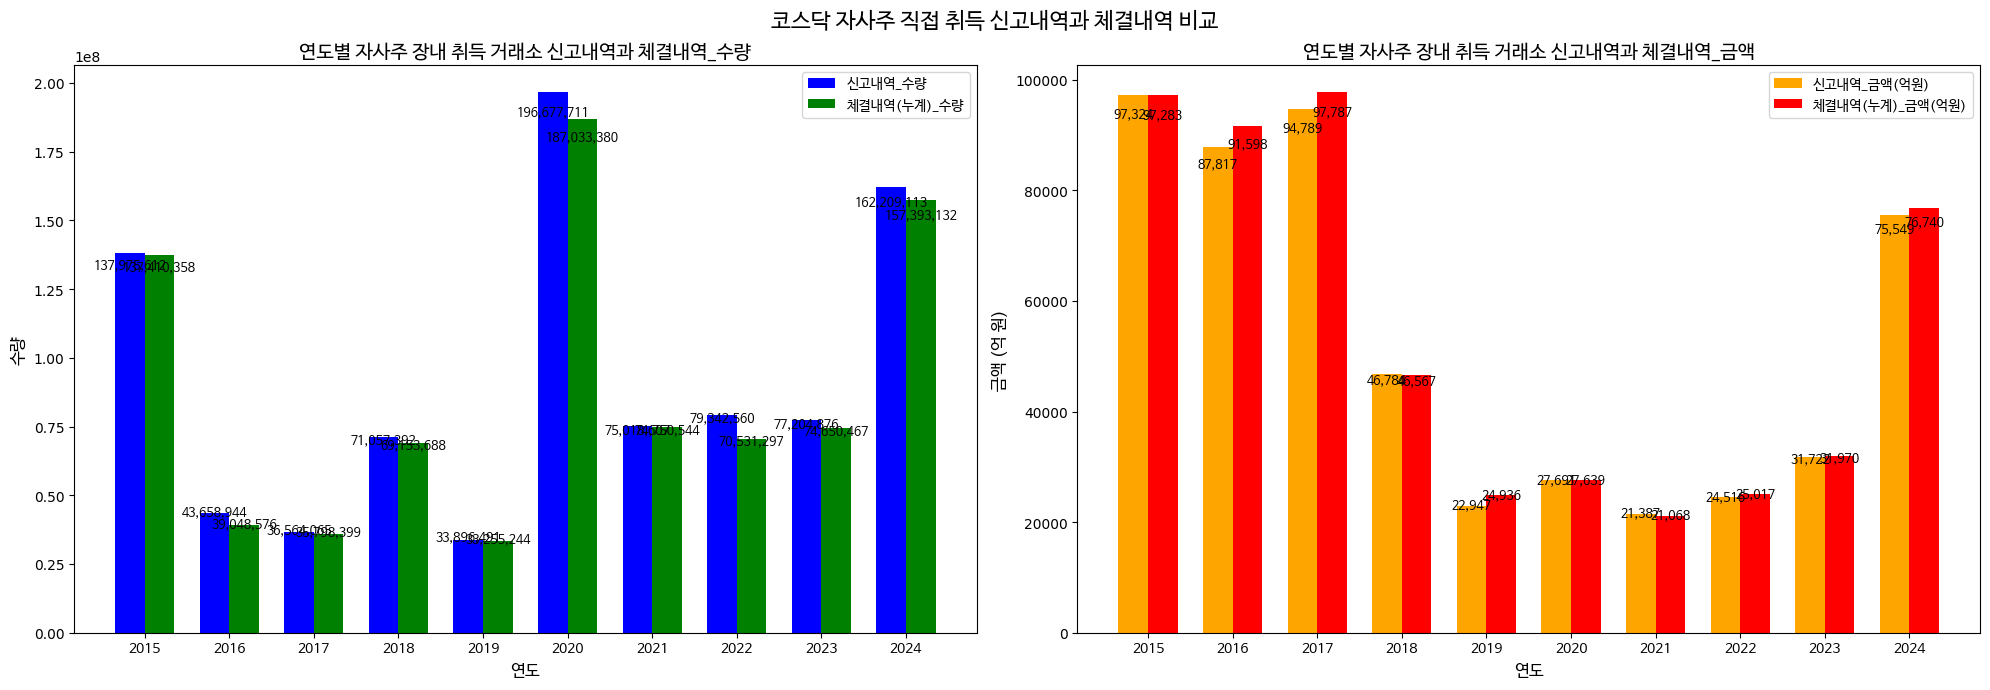

In [35]:
# 필터링할 조건 설정하기
# 시장구분: 유가
# 직접
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 &con2 &con3]

# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']
x = np.arange(len(years))  # X축 위치

# 하나의 figure에 두 개의 subplot 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 왼쪽 - 취득예정주식과 체결내역(누계)_수량 비교
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
ax1.set_title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (왼쪽 그래프)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 2. 오른쪽 - 취득예정금액과 체결내역(누계)_금액 비교
bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액(억원)'],
                width=bar_width, color='orange', label='신고내역_금액(억원)')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액(억원)'],
                width=bar_width, color='red', label='체결내역(누계)_금액(억원)')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
ax2.set_title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (오른쪽 그래프)
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# 전체 제목 추가
fig.suptitle('코스닥 자사주 직접 취득 신고내역과 체결내역 비교', fontproperties=font, fontsize=16, y=0.98)

# 하나의 그림 파일로 표시
plt.show()


### (취득) 직접취득 vs 신탁취득 비중확인하기

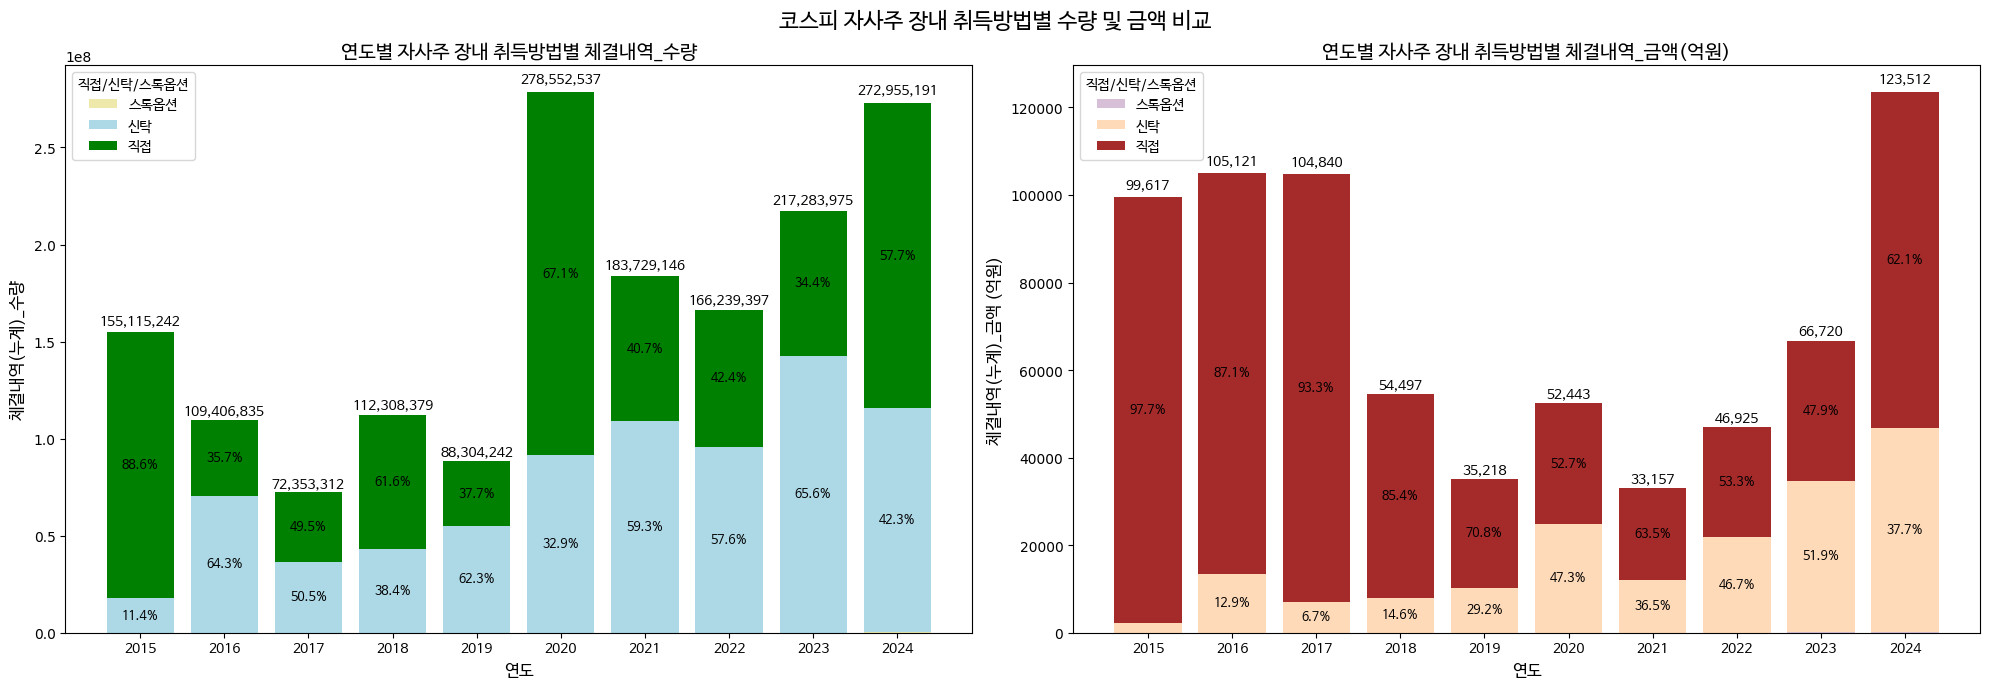

In [38]:
# 필터링할 조건 설정하기
# 시장구분: 유가
# 직접/신탁/스톡옵션
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 취득예정주식과 체결내역(누계)_수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
bottom_stack = np.zeros(len(pivot_quantity))
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 취득방법별 체결내역_수량', fontproperties=font, fontsize=14)

# 2. 취득예정금액과 체결내역(누계)_금액 비교 (오른쪽 그래프)
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액(억원)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_amount.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_amount.sum(axis=1)

for idx, col in enumerate(pivot_amount.columns):
    bars = ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_amount[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_amount[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액 (억원)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 취득방법별 체결내역_금액(억원)', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스피 자사주 장내 취득방법별 수량 및 금액 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()

### (처분) 연도별 유형별 처분수량/처분금액 구하기

In [10]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 유가
# 직접
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 &con3]

# 확인해보기
print("행의 개수: " + str(len(grouped_con)))

# 확인해보기
print('확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 1. 거래량 칼럼에 format_number 적용
df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']] = df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']].map(format_number)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 16
확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>시장구분</th>
      <th>year</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>신고내역_수량</th>
      <th>체결내역(누계)_수량</th>
      <th>신고내역_금액(억원)</th>
      <th>체결내역(누계)_금액(억원)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KOSPI</td>
      <td>2015</td>
      <td>신탁</td>
      <td>처분</td>
      <td>0</td>
      <td>26,158</td>
      <td>10</td>
      <td>4</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2015</td>
      <td>직접</td>
      <td>처분</td>
      <td>24,586,221</td>
      <td>24,518,342</td>
      <td>4,622</td>
      <td>4,566</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2016</td>
      <td>직접</td>
      <td>처분</td>
      <td>42,187,315</td>
      <td>42,184,600</td>
      <td>3,863</td>
      <td>3,780</td>
    </tr>
    <tr>
      <td>KOSPI</td>
      <td>2017</td>
      <td>신탁</td>
      <td>처분</td>
      <td>0</td>
      <td>612,645

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,체결내역(누계)_수량,신고내역_금액(억원),체결내역(누계)_금액(억원)
62,KOSPI,2015,신탁,처분,0,"26,158",10,4
64,KOSPI,2015,직접,처분,"24,586,221","24,518,342","4,622","4,566"
67,KOSPI,2016,직접,처분,"42,187,315","42,184,600","3,863","3,780"
69,KOSPI,2017,신탁,처분,0,"612,645",220,33
71,KOSPI,2017,직접,처분,"54,697,984","53,336,381","10,701","10,561"
73,KOSPI,2018,신탁,처분,0,"345,019",45,13
75,KOSPI,2018,직접,처분,"31,002,560","31,000,504","1,629","1,605"
77,KOSPI,2019,신탁,처분,0,"200,000",20,14
79,KOSPI,2019,직접,처분,"23,049,059","22,764,264","1,157","1,132"
81,KOSPI,2020,신탁,처분,0,"1,276,626",70,107


### (처분) 자사주 처분 신고대비 실제 처분 확인하기(장내처분限)
처분방법에는 '직접/신탁'이 있는데, 거래소에 사전신고하는 것은 '직접'에만 해당<br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

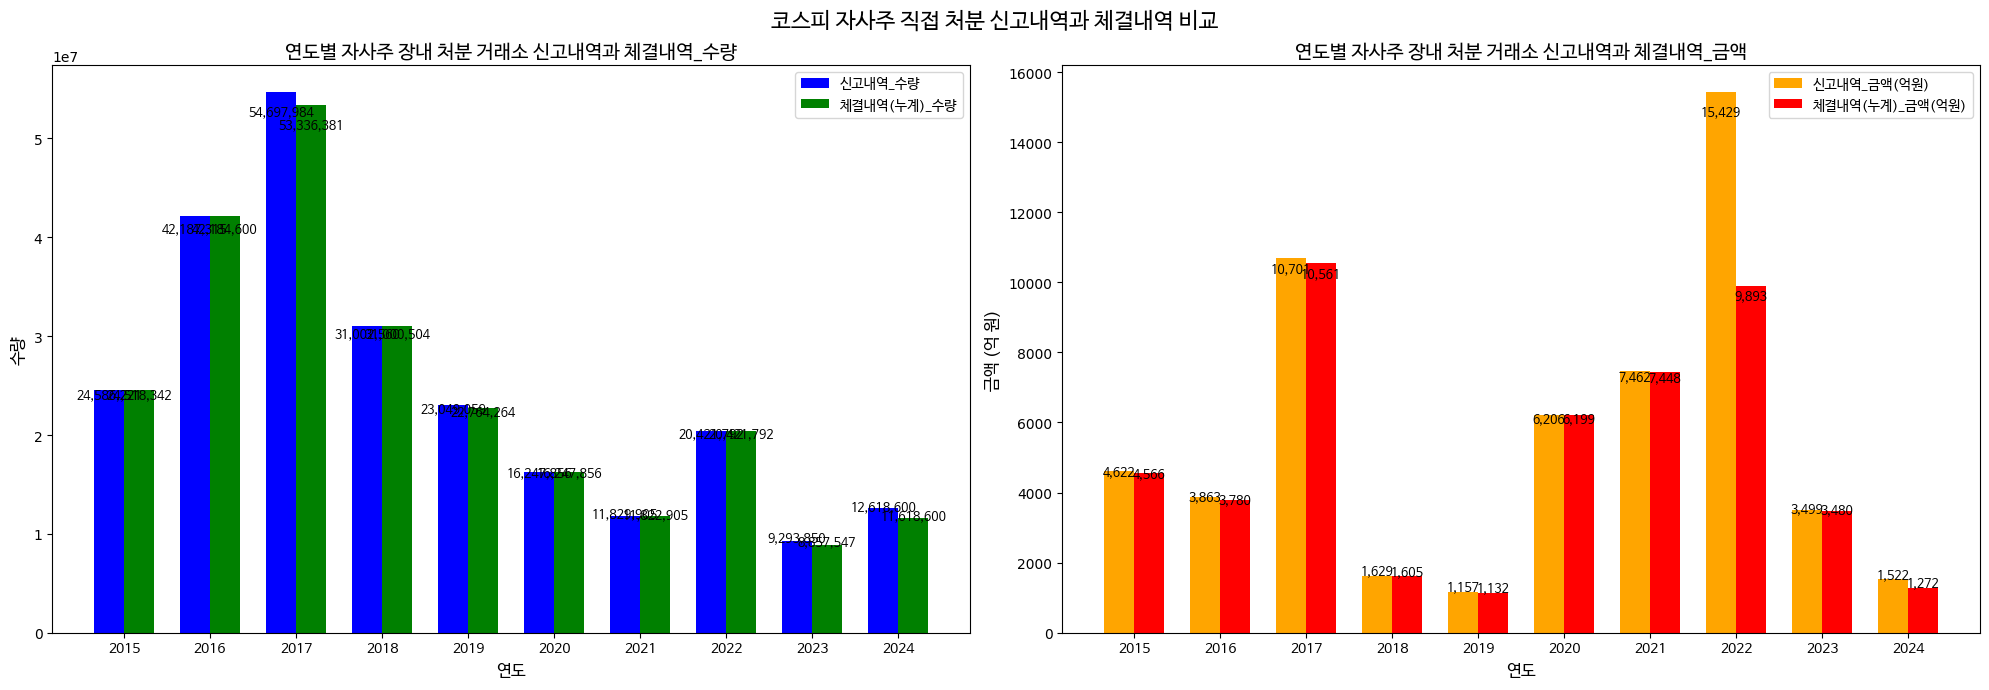

In [36]:
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con2 & con3]

# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']
x = np.arange(len(years))  # X축 위치

# 하나의 figure에 두 개의 subplot 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 왼쪽 - 처분예정주식과 체결내역(누계)_수량 비교
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
ax1.set_title('연도별 자사주 장내 처분 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (왼쪽 그래프)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 2. 오른쪽 - 처분예정금액과 체결내역(누계)_금액 비교
bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액(억원)'],
                width=bar_width, color='orange', label='신고내역_금액(억원)')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액(억원)'],
                width=bar_width, color='red', label='체결내역(누계)_금액(억원)')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
ax2.set_title('연도별 자사주 장내 처분 거래소 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (오른쪽 그래프)
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# 전체 제목 추가
fig.suptitle('코스피 자사주 직접 처분 신고내역과 체결내역 비교', fontproperties=font, fontsize=16, y=0.98)

# 하나의 그림 파일로 표시
plt.show()


### (처분) 직접처분 vs 신탁처분 비중확인하기

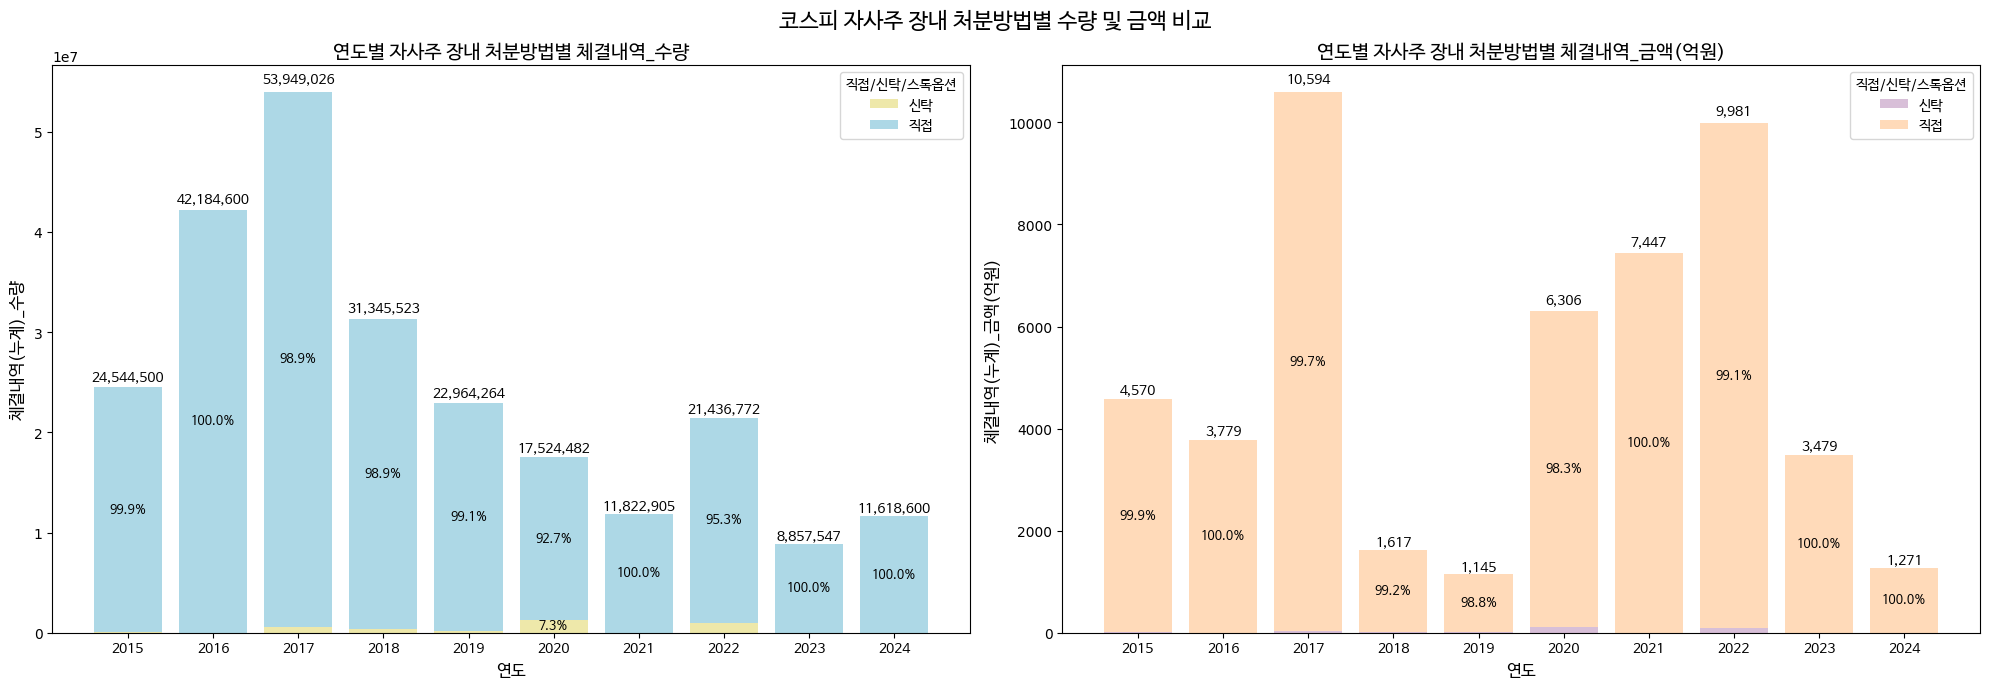

In [37]:
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
#con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 처분예정주식과 체결내역(누계)_수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 처분방법별 체결내역_수량', fontproperties=font, fontsize=14)

# 2. 처분예정금액과 체결내역(누계)_금액 비교 (오른쪽 그래프)
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액(억원)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_amount.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_amount.sum(axis=1)

for idx, col in enumerate(pivot_amount.columns):
    bars = ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_amount[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_amount[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액(억원)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 처분방법별 체결내역_금액(억원)', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스피 자사주 장내 처분방법별 수량 및 금액 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()


## 코스닥 법인 추이보기

### (취득) 연도별 유형별 취득수량/취득금액 구하기

In [15]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 코스닥
# 직접
# 취득

con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 &con3]

# 확인해보기
print("행의 개수: " + str(len(grouped_con)))

# 확인해보기
print('확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 1. 거래량 칼럼에 format_number 적용
df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']] = df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']].map(format_number)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 23
확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>시장구분</th>
      <th>year</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>신고내역_수량</th>
      <th>체결내역(누계)_수량</th>
      <th>신고내역_금액(억원)</th>
      <th>체결내역(누계)_금액(억원)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KOSDAQ</td>
      <td>2015</td>
      <td>신탁</td>
      <td>취득</td>
      <td>0</td>
      <td>21,547,130</td>
      <td>2,780</td>
      <td>1,941</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2015</td>
      <td>직접</td>
      <td>취득</td>
      <td>20,295,537</td>
      <td>18,810,977</td>
      <td>2,022</td>
      <td>1,970</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2016</td>
      <td>신탁</td>
      <td>취득</td>
      <td>0</td>
      <td>21,567,869</td>
      <td>4,776</td>
      <td>3,332</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2016</td>
      <td>직접</td>
      <td>취득</td>
      <td>20,102,025</td>
  

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,체결내역(누계)_수량,신고내역_금액(억원),체결내역(누계)_금액(억원)
20,KOSDAQ,2015,신탁,취득,0,"21,547,130","2,780","1,941"
22,KOSDAQ,2015,직접,취득,"20,295,537","18,810,977","2,022","1,970"
24,KOSDAQ,2016,신탁,취득,0,"21,567,869","4,776","3,332"
26,KOSDAQ,2016,직접,취득,"20,102,025","19,096,771","3,192","3,257"
28,KOSDAQ,2017,신탁,취득,0,"31,954,656","4,189","3,127"
30,KOSDAQ,2017,직접,취득,"17,147,195","14,472,834","1,253","1,252"
32,KOSDAQ,2018,신탁,취득,0,"59,004,459","8,009","6,073"
34,KOSDAQ,2018,직접,취득,"36,423,571","33,486,621","4,870","4,888"
35,KOSDAQ,2019,스톡옵션,취득,"323,000","35,018",5,1
37,KOSDAQ,2019,신탁,취득,0,"37,416,422","4,237","2,961"


### (취득) 자사주 취득 신고대비 실제 취득 확인하기(장내취득限)
취득방법에는 '직접/신탁/스톡옵션'이 있는데, 거래소에 사전신고하는 것은 '직접'에만 해당<br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

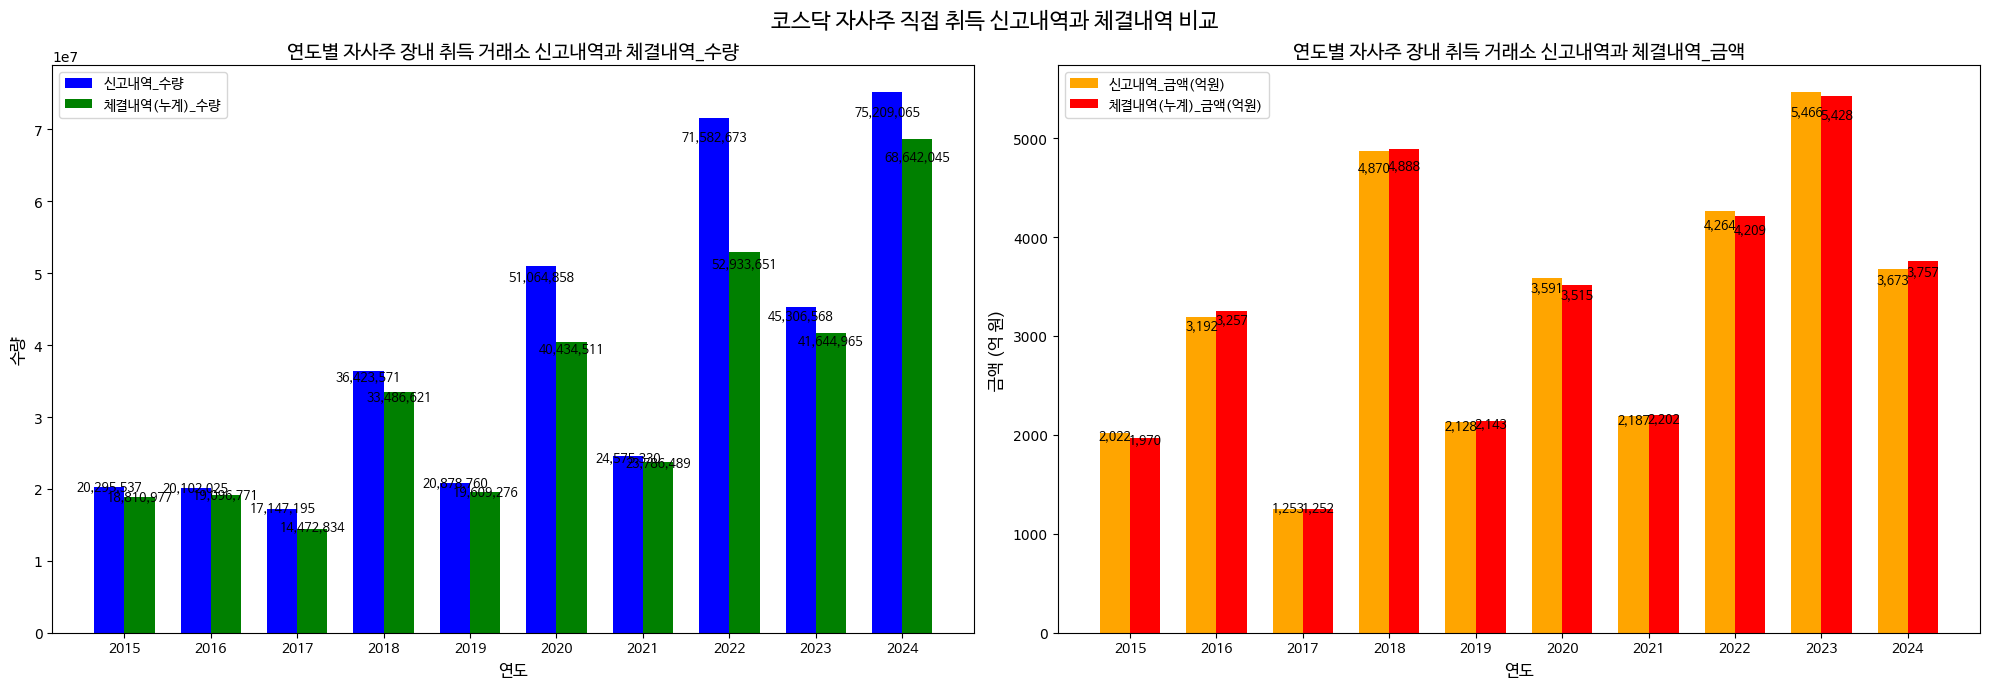

In [32]:
# 필터링할 조건 설정하기
# 시장구분: 코스닥, 직접, 취득
con1 = grouped['시장구분'] == 'KOSDAQ'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con2 & con3]

# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']
x = np.arange(len(years))  # X축 위치

# 하나의 figure에 두 개의 subplot 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 왼쪽 - 취득예정주식과 체결내역(누계)_수량 비교
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
ax1.set_title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (왼쪽 그래프)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 2. 오른쪽 - 취득예정금액과 체결내역(누계)_금액 비교
bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액(억원)'],
                width=bar_width, color='orange', label='신고내역_금액(억원)')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액(억원)'],
                width=bar_width, color='red', label='체결내역(누계)_금액(억원)')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
ax2.set_title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (오른쪽 그래프)
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# 전체 제목 추가
fig.suptitle('코스닥 자사주 직접 취득 신고내역과 체결내역 비교', fontproperties=font, fontsize=16, y=0.98)

# 하나의 그림 파일로 표시
plt.show()


### (취득) 직접취득 vs 신탁취득 비중확인하기

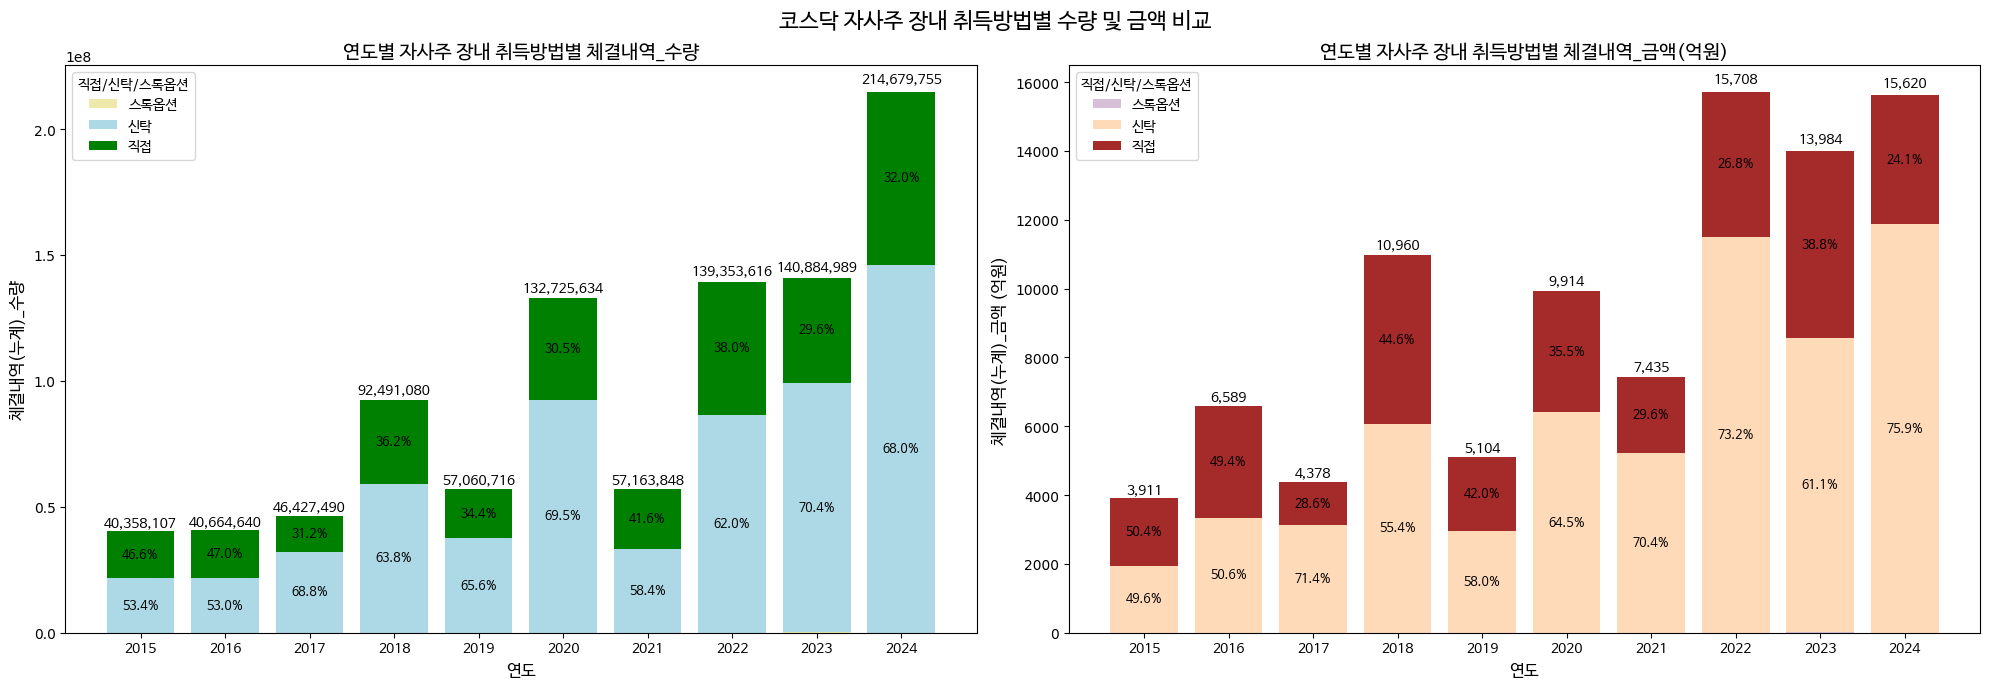

In [39]:
# 필터링할 조건 설정하기
# 시장구분: 코스닥
# 직접/신탁/스톡옵션
# 취득

con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 취득예정주식과 체결내역(누계)_수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 취득방법별 체결내역_수량', fontproperties=font, fontsize=14)

# 2. 취득예정금액과 체결내역(누계)_금액 비교 (오른쪽 그래프)
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액(억원)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_amount.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_amount.sum(axis=1)

for idx, col in enumerate(pivot_amount.columns):
    bars = ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_amount[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_amount[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액 (억원)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 취득방법별 체결내역_금액(억원)', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스닥 자사주 장내 취득방법별 수량 및 금액 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()

### (처분) 연도별 유형별 처분수량/처분금액 구하기

In [20]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 코스닥
# 직접
# 처분

con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 &con3]

# 확인해보기
print("행의 개수: " + str(len(grouped_con)))

# 확인해보기
print('확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 1. 거래량 칼럼에 format_number 적용
df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']] = df_show[['신고내역_수량','체결내역(누계)_수량','신고내역_금액(억원)', '체결내역(누계)_금액(억원)']].map(format_number)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 20
확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>시장구분</th>
      <th>year</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>신고내역_수량</th>
      <th>체결내역(누계)_수량</th>
      <th>신고내역_금액(억원)</th>
      <th>체결내역(누계)_금액(억원)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KOSDAQ</td>
      <td>2015</td>
      <td>신탁</td>
      <td>처분</td>
      <td>0</td>
      <td>1,815,928</td>
      <td>110</td>
      <td>132</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2015</td>
      <td>직접</td>
      <td>처분</td>
      <td>64,644,329</td>
      <td>63,747,106</td>
      <td>4,317</td>
      <td>4,158</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2016</td>
      <td>신탁</td>
      <td>처분</td>
      <td>0</td>
      <td>512,849</td>
      <td>60</td>
      <td>52</td>
    </tr>
    <tr>
      <td>KOSDAQ</td>
      <td>2016</td>
      <td>직접</td>
      <td>처분</td>
      <td>20,313,993</td>
      <td>17,685

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,체결내역(누계)_수량,신고내역_금액(억원),체결내역(누계)_금액(억원)
19,KOSDAQ,2015,신탁,처분,0,"1,815,928",110,132
21,KOSDAQ,2015,직접,처분,"64,644,329","63,747,106","4,317","4,158"
23,KOSDAQ,2016,신탁,처분,0,"512,849",60,52
25,KOSDAQ,2016,직접,처분,"20,313,993","17,685,768","1,607","1,504"
27,KOSDAQ,2017,신탁,처분,0,"1,000,537",50,60
29,KOSDAQ,2017,직접,처분,"17,317,269","16,769,277","2,142","2,070"
31,KOSDAQ,2018,신탁,처분,0,"1,565,486",120,71
33,KOSDAQ,2018,직접,처분,"11,061,481","10,609,169","1,991","1,944"
36,KOSDAQ,2019,신탁,처분,0,"544,819",35,35
38,KOSDAQ,2019,직접,처분,"6,404,550","6,404,550",815,799


### (처분) 자사주 처분 신고대비 실제 처분 확인하기(장내처분限)
처분방법에는 '직접/신탁'이 있는데, 거래소에 사전신고하는 것은 '직접'에만 해당<br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

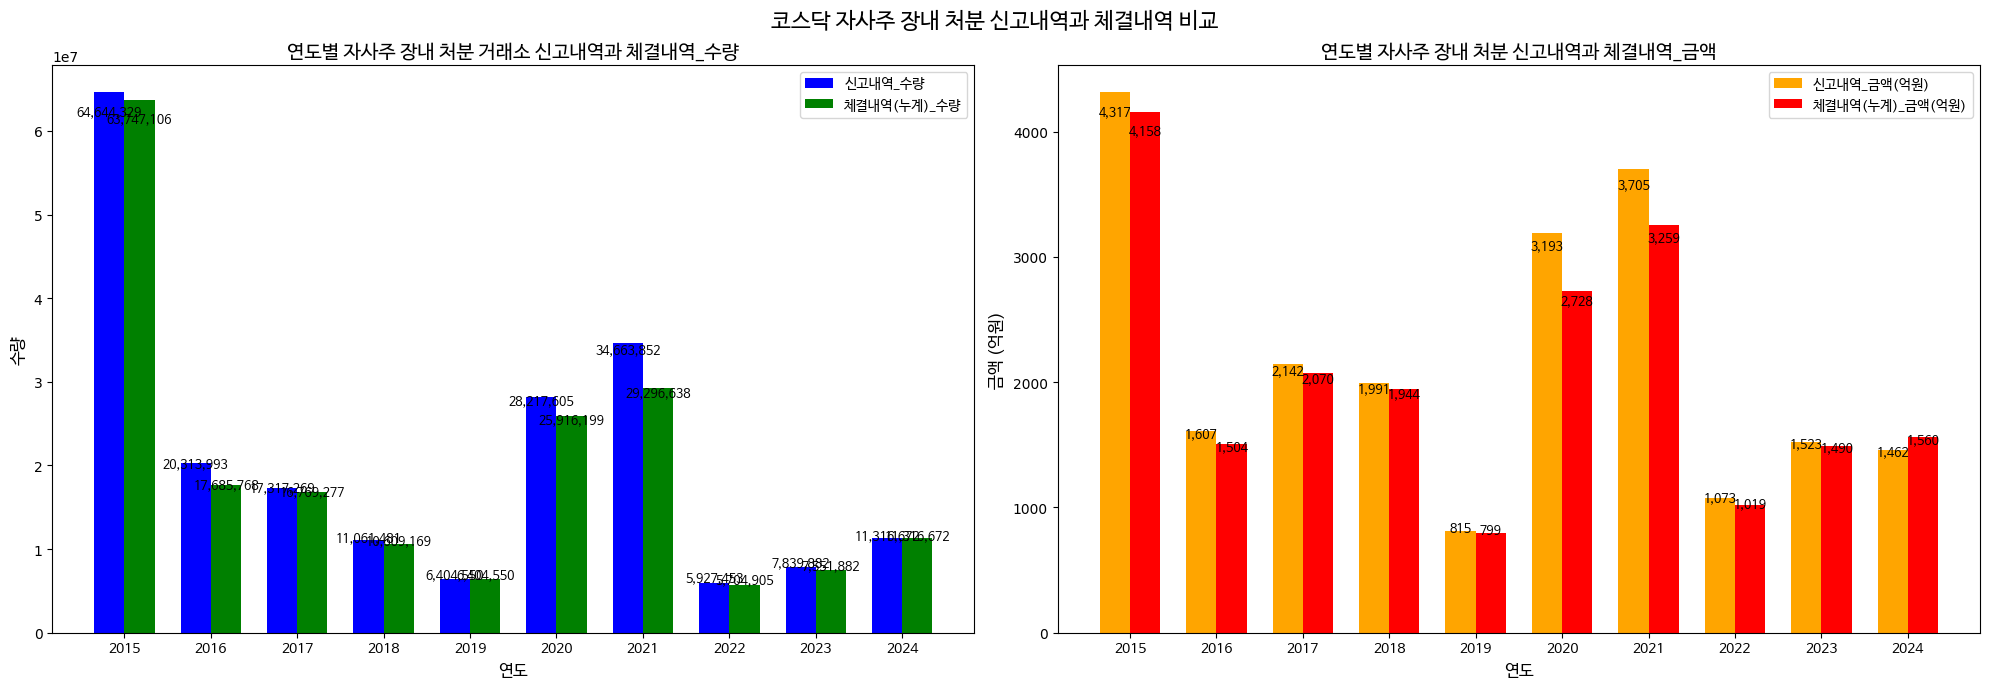

In [40]:
# 시장구분: 코스닥
# 처분

con1 = grouped['시장구분'] == 'KOSDAQ'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con2 & con3]

# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']
x = np.arange(len(years))  # X축 위치

# 하나의 figure에 두 개의 subplot 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 왼쪽 - 취득예정주식과 체결내역(누계)_수량 비교
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
ax1.set_title('연도별 자사주 장내 처분 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (왼쪽 그래프)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 2. 오른쪽 - 취득예정금액과 체결내역(누계)_금액 비교
bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액(억원)'],
                width=bar_width, color='orange', label='신고내역_금액(억원)')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액(억원)'],
                width=bar_width, color='red', label='체결내역(누계)_금액(억원)')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
ax2.set_title('연도별 자사주 장내 처분 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가 (오른쪽 그래프)
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# 전체 제목 추가 (선택 사항)
fig.suptitle('코스닥 자사주 장내 처분 신고내역과 체결내역 비교', fontproperties=font, fontsize=16, y=0.98)

# 하나의 그림 파일로 저장
plt.show()


### (처분) 직접처분 vs 신탁처분 비중확인하기

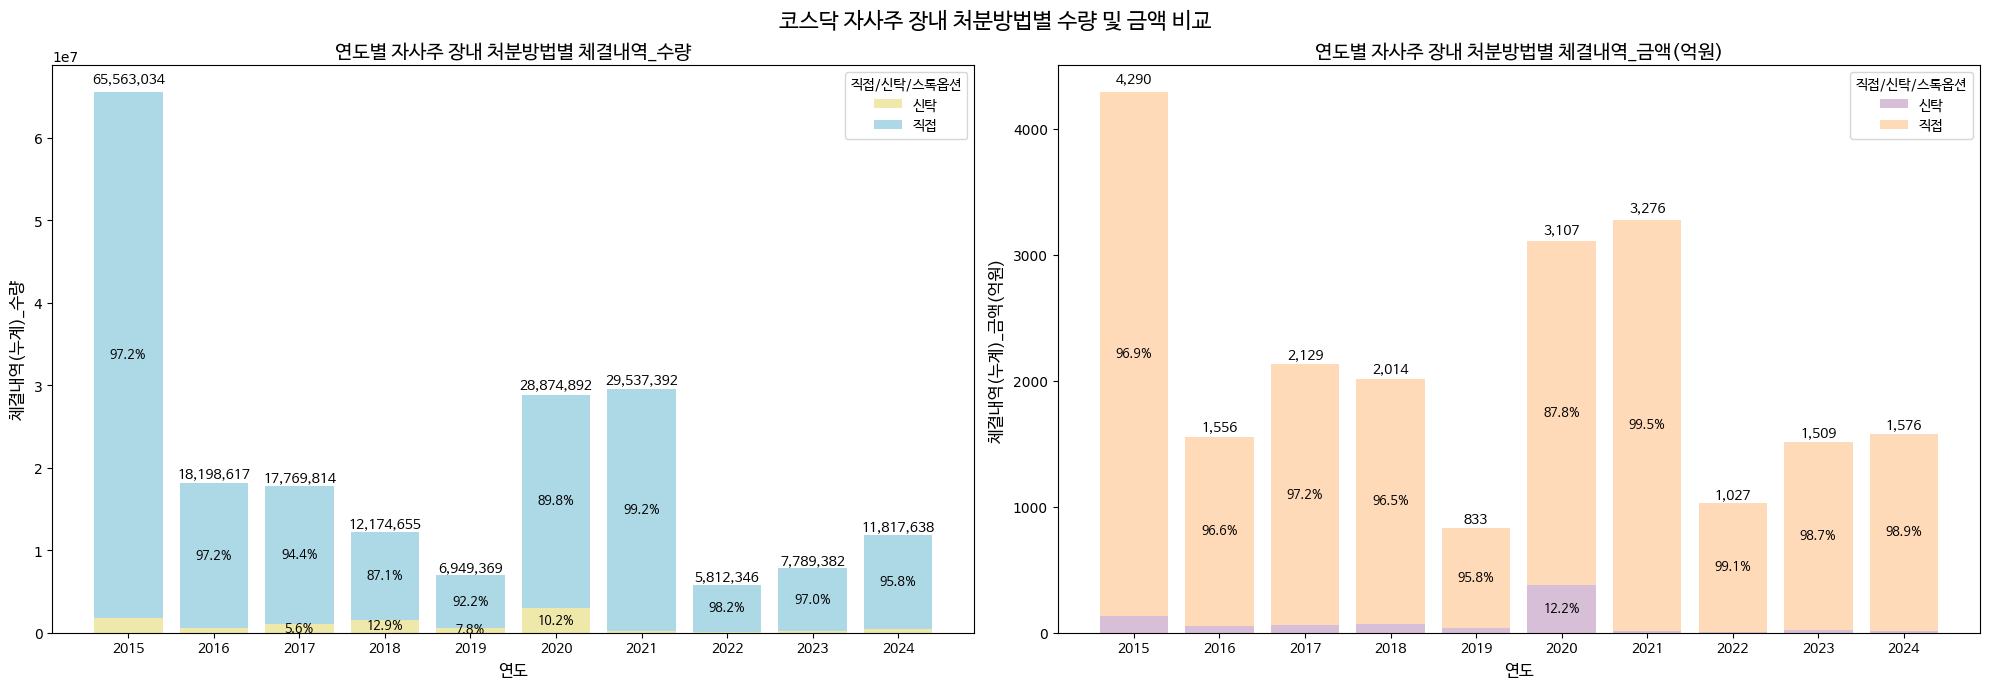

In [41]:
# 시장구분: 코스닥
# 처분

con1 = grouped['시장구분'] == 'KOSDAQ'
#con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1. 처분예정주식과 체결내역(누계)_수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 처분방법별 체결내역_수량', fontproperties=font, fontsize=14)

# 2. 처분예정금액과 체결내역(누계)_금액 비교 (오른쪽 그래프)
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액(억원)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_amount.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_amount.sum(axis=1)

for idx, col in enumerate(pivot_amount.columns):
    bars = ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_amount[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_amount[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액(억원)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 처분방법별 체결내역_금액(억원)', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스닥 자사주 장내 처분방법별 수량 및 금액 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()
